## Imaging and the FFT
_Notebook for engineers by Griffin Foster_

The Fourier transform relates the spatial domain (i.e. an image) to the spatial frequency domain (i.e. the visibilities)

If $I(l,m)$ represents an image, i.e. a discrete 2-dimensional function, then we see that $I(l,m)$ can be represented as the Fourier Transform of the visibilities $V(u,v)$. By Euler's formula the Fourier Transform is the decomposition of the visibilties into sine and cosine functions.

$ I(l,m) = \sum_{u=-\infty}^{\infty} \sum_{v=-\infty}^{\infty} V(u,v) (\cos(2\pi(ul+vm)) - i\sin(2\pi(ul+vm))) \,\Delta u\,\Delta v $

As the image-visibility relation can be approximated as a Fourier pair $I \rightleftharpoons V$, the visibilities $V(u,v)$ can be described as the sine/cosine decomposition of the image $I(l,m)$

$ V(u,v) = \sum_{l=-1}^{1} \sum_{m=-1}^{1} I(l,m) (\cos(2\pi(ul+vm)) + i\sin(2\pi(ul+vm))) \,\Delta l\,\Delta m $
 
 The approximation of the relation between the image and visibilities is fundamental to using interferometry for aperture synthesis. 

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pylab as plt
import numpy as np

In [2]:
# some test images for illustration
# (Umberto Boccioni's Dynamism of a Soccer Player, and a Duck)
img0 = mpimg.imread('../images/WLA_moma_Umberto_Boccioni_Dynamism_of_a_Soccer_Player_1913_512.png')
img1 = mpimg.imread('../images/Anas_platyrhynchos_male_female_quadrat_512.png')

In [3]:
# convert to grayscale for simplicity
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b  # standard grayscale conversion
    return gray

gimg0=rgb2gray(img0)
gimg1=rgb2gray(img1)

### Images in the spatial domain
Some generic images, the first is a painting by Umberto Boccioni called Dynamism of a Cyclist and the other is a duck (well, one full male mallard and part of a female mallard).

Displaying the images in the spatial domain, i.e. the domain we usually look at images in. We use the term spatial domain to describe signals which are ordered by a distance which is directly related to the physical distance between the two signals, e.g. for the duck image below the eye is close to the head and far away from the foot as it is in the real world.

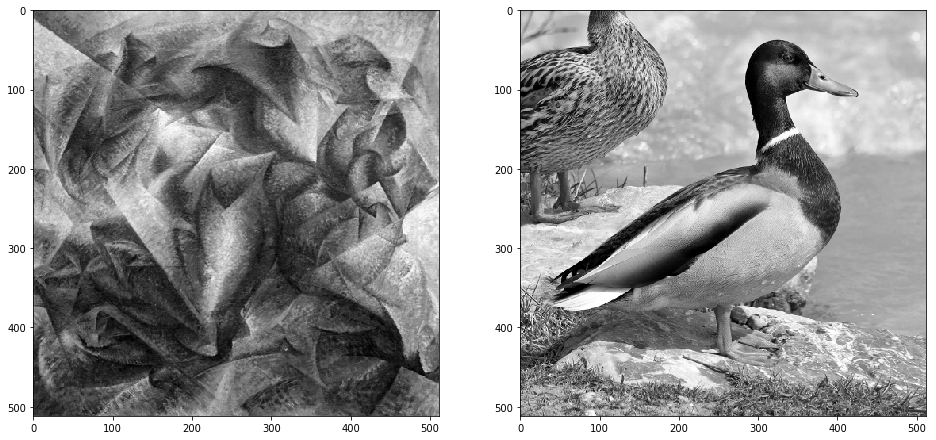

In [4]:
fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
img0plot = plt.imshow(gimg0)
img0plot.set_cmap('gray')

plt.subplot(1,2,2)
img1plot=plt.imshow(gimg1)
img1plot.set_cmap('gray')

The spatial frequency domain (via a 2-dimensional Fourier Transform) represents the decomposition of a spatial domain signal into complex sinusoidal waves.

This results in a complex 2-d array where the pixels closest to the centre of the array represent the low-frequency, or 'large-scale', structure of the original image. At the edge of the array are the high-frequency, or 'fine-scale', structure of the image. The high-frequency components represent the details of the image.

In the amplitude figures (top) the majority of the power is in the central region, i.e. the majority of the signal can be represented with large scale, or low-frequency sinusoidal waves.   
In the phase figures (bottom) the values range from $-2\pi$ to $2\pi$ and are fairly random. There is some coherent structure that goes left to right and top to bottom passing through the centre of the figure. The main insight to gain from the phase figure is that given a complex image, of say a duck for example, leads to very complex phase structure.

In [5]:
# Convert the images to the spatial frequency domain
fftImg0=np.fft.fftshift(np.fft.fft2(gimg0))
fftImg1=np.fft.fftshift(np.fft.fft2(gimg1))

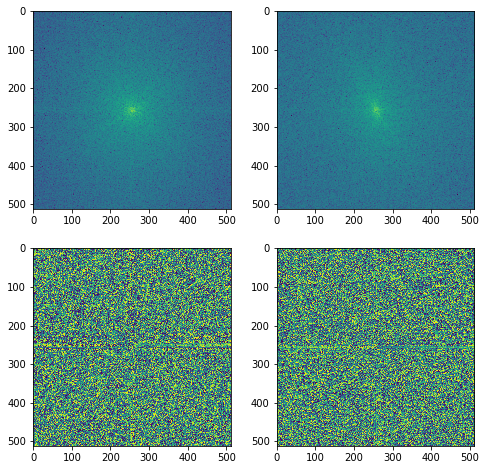

In [6]:
# Complex values have both amplitude (A) and phase (theta): A*exp(i*theta)
fig, axes = plt.subplots(figsize=(8,8))
plt.subplot(2,2,1)
# amplitude
plt.imshow(10.*np.log10(np.abs(fftImg0)))
plt.subplot(2,2,3)
# phase
plt.imshow(np.angle(fftImg0))
plt.subplot(2,2,2)
# amplitude
plt.imshow(10.*np.log10(np.abs(fftImg1)))
plt.subplot(2,2,4)
# phase
plt.imshow(np.angle(fftImg1))

### Hybrid image in the spatial frequency domain
It turns out that phase information contains most of the structural information.
Combining the two images (using half the information from each) and use the phase of the painting and the amplitude of the duck --- we only see the painting and not the duck.

Though with the hybrid image, the image in which the phase is extracted from dominates it are not perfectly reconstructed. There is a sheen of noise across the image. The amplitude information plays a role. This noisiness of the hybrid image is due to the fact that the two original images are effectly uncorrelated, i.e. they are not related. So, one would not expect the amtplitude and phase information from one to match the other.

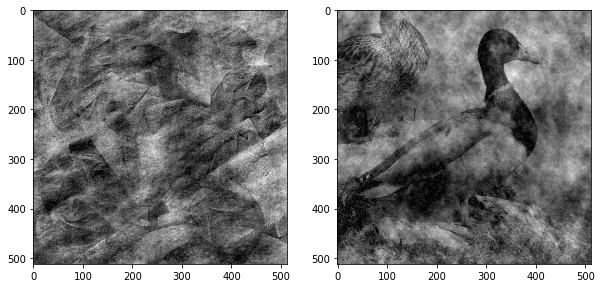

In [7]:
fig = plt.figure(figsize=(10,5))
# Hybrid image with phase of Soccer and amplitude of Duck
phs=np.angle(fftImg0)
amp=np.abs(fftImg1)
fftHybrid=amp*(np.cos(phs)+1j*np.sin(phs))
# Reconstruct hybrid image
plt.subplot(1,2,1)
hybrid=np.abs(np.fft.ifft2(np.fft.fftshift(fftHybrid)))
hybridPlot=plt.imshow(hybrid)
hybridPlot.set_cmap('gray')

# Hybrid image with amplitude of Soccer and phase of Duck
phs=np.angle(fftImg1)
amp=np.abs(fftImg0)
fftHybrid=amp*(np.cos(phs)+1j*np.sin(phs))
# Reconstruct hybrid image
plt.subplot(1,2,2)
hybrid=np.abs(np.fft.ifft2(np.fft.fftshift(fftHybrid)))
hybridPlot=plt.imshow(hybrid)
hybridPlot.set_cmap('gray')

A way to think about the phase and amplitude information is that phase information describes the structure of an image, that is, where the power needs to be placed.   
Ampltiude information describes the intensity of that structure given a position.

The constructive and destructive interference of all the sinusoidal waves leads to a reconstruction of the image. If the amplitudes of all the sinusoidal waves is unity then there is still interference between the waves leading to a partial image. But, if the phase information is gone then there will be no interference and there will only be noise in the reconstructed image.

### Building up an Image from Sampled Visibilities
Starting with the Fourier transformed duck image shown at the beginning of the section, we can construct a new image by selecting a few sample points with what is called a sampling function in the spatial frequency domain and creating a new image.

In [8]:
def reconstructImage(vis, nsamples):
    """randomly select a few values from the spatial frequency (visibility) domain
    and reconstruct the image with those samples. To do a full reconstruction of the
    image, nsamples needs to be larger than the total number of pixels in the image
    because the np.random.randint() chooses with replacement so positions will be
    doubles counted"""
    subVis = np.zeros_like(vis)
    ypos = np.random.randint(0, vis.shape[0]-1, size=nsamples)
    xpos = np.random.randint(0, vis.shape[1]-1, size=nsamples)
    subVis[ypos, xpos] = vis[ypos, xpos] #insert a subset of visibilities
    newImg = np.abs(np.fft.ifft2(np.fft.fftshift(subVis)))
    
    fig, axes = plt.subplots(figsize=(7, 3))
    plt.subplot(1,2,1)
    plt.title('Sampled Visibilities')
    plt.imshow(np.abs(subVis).astype(bool), interpolation='nearest')
    plt.set_cmap('gray')
    
    plt.subplot(1,2,2)
    plt.title('Reconstructed Image')
    plt.imshow(newImg)
    plt.set_cmap('gray')

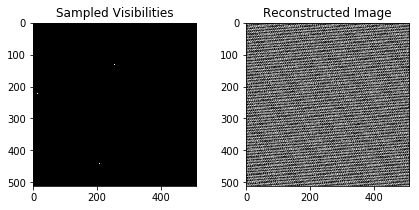

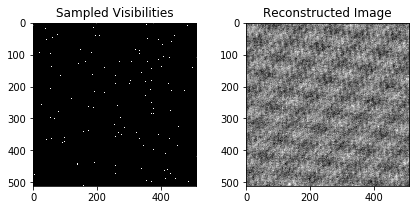

In [9]:
reconstructImage(fftImg1, int(1e1))
reconstructImage(fftImg1, int(1e3))

By only using a few sampled spatial frequency modes the resulting image looks only like a collection of sinusoidal waves with random amplitudes and orientations.

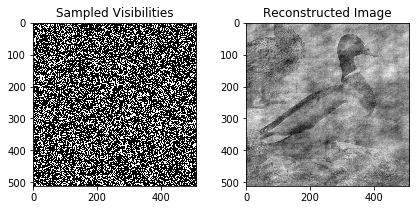

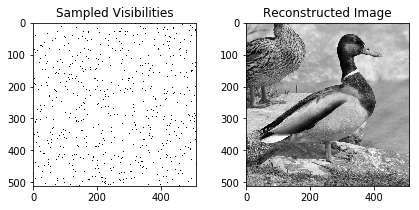

In [10]:
reconstructImage(fftImg1, int(1e5))
reconstructImage(fftImg1, int(1e6))

As we progressively increase the number of sampled positions structure starts to appear until eventually the original duck image re-emerges.

Basically, we are selecting a collection of spatial frequencies, giving them different amplitudes and creating an image out of those components, we just happen to be picking ones such that we are constructing a duck. But, any image can be constructed by setting the correct amplitudes and phases of various spatial frequencies.

In the final image we can see the visibility space is not fully sampled, but since the majority of positions are sampled it is difficult to see any difference in the resulting image compared to the original. This is an important point, we don't need to sample all the spatial frequency modes to reconstruct an image that is very similar to the original.

### Sampling and Point Spread Functions 

An interferometric array measures, i.e. samples, the continuous visibility domain function. These measurements, colloquially called visibilities, can be used to reconstruct, at least partially, an image of the sky.

We showed that random sampling of the spatial frequency (visibility) domain reconstructs the original image to varying degrees of quality dependent on the number of samples used.   
In this section we will expand on that idea to show how different samplings of the visibility space will result in different characteristics in the image domain.

A standard method to convert a continuous signal into a discrete signal to apply a regularly-spaced function called a Shah (or Dirac comb, or bed of nails) function to the continous signal.
We can use this function to sample a continuous sky image into a digital image, such as is done with a telescope and CCD camera. But, in radio astronomy that is not possible due to a number of issues with scale, technology, and sensitivity. Instead, we use an irregular sampling method.

In radio astronomy the sampling functions will be a function of the interferometric array configuration, observation bandwidth, sky pointing direction, and data flagging among other issues. The general 2-D sampling function form an arbitrary set of sampling pairs.    
By sampling a function we are inherently losing information as we are only measuring part of a signal. The next step is to understand how our choice of sampling effects what we can recover, especially when we are sampling in the spatial frequency (visibility) domain to recover an image in the spatial (image) domain.

The term Point Spread Function comes up in a lot of astronomy and photography, the term refers to the response of a measurement system to perfect point source. In optical astronomy stars are usually 'unresolved', that is the resolution of the telescope is insufficient to measure the angular size of the star. So, a star can effectively be considered a point source. The optics of the telescope then impose a structure on the entire image which can be seen in strong point sources.

When discussing radio interferometry the term PSF relates to the geometry of the array configuration, that is how the array samples the visibility domain. Stated simply: the PSF of an interferometric array (in fact any telescope) is the Fourier transform of the visibility domain sampling function.

$\text{PSF}(l,m) \rightleftharpoons S(u,v)$

The term synthesized beam is sometimes used, this is equivalent to the PSF.

The resulting observed signal from a measurement system is the convolution of the true signal with the PSF of the system

$I_{obs} = \text{PSF} \circ I_{true} $

Use a simple circular aperture which refracts light to a measurement plane, this is a refracting telescope in the style of Galileo's original design. The aperture, which has a certain circumference defines the maximum resolution of the telescope and the 2-D cross section of the aperture, a disk, is the 'sampling' function. That is, all light within the circumference of the lense is seen, and all light beyond the lense is excluded. The sampling function of this telescope is a binary disk.

Text(0.5,1,u'PSF')

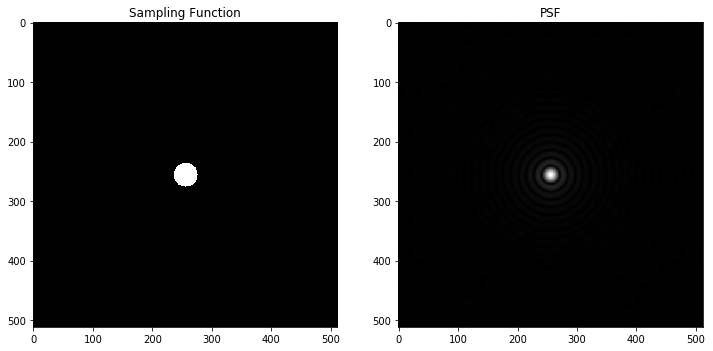

In [11]:
def circularSamplingMap(imgSize, outer, inner=0):
    """Return a circular sampling map of size [imgSize, imgSize]
    imgSize: image size in pixels
    outer: outer radius (in pixels) to exclude sampling above
    inner: inner radius (in pixels) to exclude sampling below"""
    zeros = np.zeros((imgSize,imgSize), dtype='float')
    ones = np.ones((imgSize,imgSize), dtype='float')
    xpos, ypos = np.mgrid[0:imgSize,0:imgSize]
    radius = np.sqrt((xpos - imgSize/2)**2. + (ypos - imgSize/2)**2.)
    sampling = np.where((outer >= radius) & (radius >= inner), ones, zeros)
    return sampling

sampling = circularSamplingMap(512, 20, 0)
fig, axes = plt.subplots(figsize=(12,6))
plt.subplot(1,2,1)
samplingPlot = plt.imshow(sampling)
plt.title('Sampling Function')
samplingPlot.set_cmap('gray')

# We can then compute the PSF of this telescope using a Fourier transform.
plt.subplot(1,2,2)
psfPlot = plt.imshow(np.abs( np.fft.fftshift( np.fft.fft2(sampling))))
plt.title('PSF')

Looking at the PSF there is large (in amplitude) central peak surrounding by rings which drop off in amplitude. This is known as an Airy disk (also called a Bessel function of the first kind, or radially symetric Sinc function), and is the Fourier transform of a radially symetric top-hat function which is what our simple sampling function is. The central peak is often called the PSF primary lobe and the secodary peaks, such as the rings, are the PSF sidelobes.

Remember, the PSF is the response of the measuring system to a point source, in this example we see that a point source will appear to be an Airy disk with a primary lobe of many pixels in size. 

We can produce the observed image of the duck image from the previous section by taking advantage of the Fourier relation in the convolution theorem that a convolution of two function in one domain is a multiplication of those functions in the Fourier domain

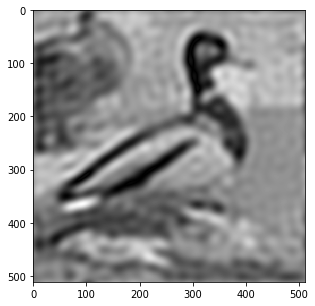

In [12]:
obsDuck = np.abs(np.fft.ifft2(np.fft.fftshift(sampling * fftImg1))) #multiple by the sampling function, and
                                                                    #Fourier transfrom back to the image domain
fig, axes = plt.subplots(figsize=(5,5))
obsPlot = plt.imshow(obsDuck)
obsPlot.set_cmap('gray')

The observed image is quite blurry as the large PSF primary lobe affectively acts as a low-pass filter to remove the fine details. By increasing the radius of the sampling function, i.e. using a larger telescope, we see that the PSF primary lobe gets smaller, and thus we have a higher resolution telescope as expected.

Text(0.5,1,u'PSF')

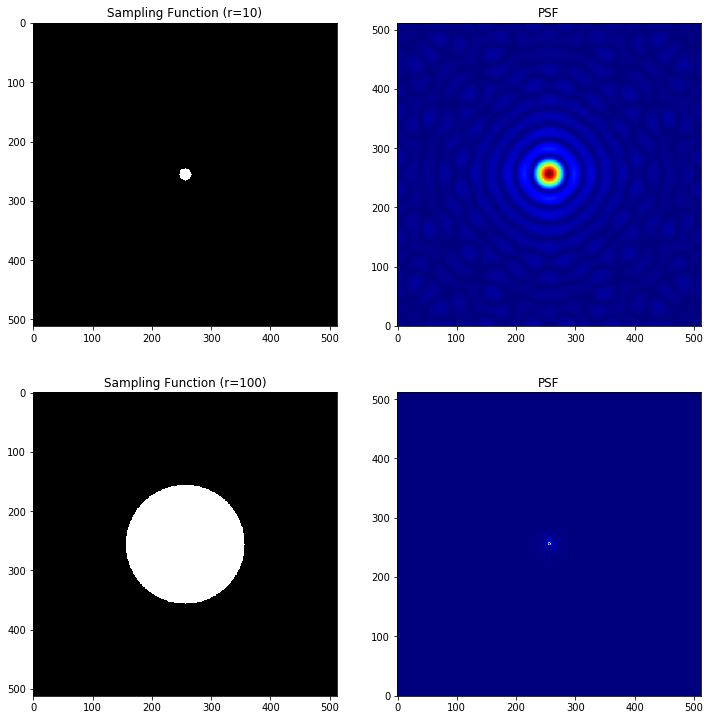

In [13]:
fig, axes = plt.subplots(figsize=(10, 10))
fig.tight_layout()

plt.subplot(2,2,1)
sampling0 = circularSamplingMap(512, 10, 0)
samplingPlot = plt.imshow(sampling0)
samplingPlot.set_cmap('gray')
plt.title('Sampling Function (r=%i)'%10)

plt.subplot(2,2,3)
sampling1 = circularSamplingMap(512, 100, 0)
samplingPlot = plt.imshow(sampling1)
samplingPlot.set_cmap('gray')
plt.title('Sampling Function (r=%i)'%100)

plt.subplot(2,2,2)
psfPlot = plt.imshow(np.abs( np.fft.fftshift( np.fft.fft2(sampling0))), cmap=plt.get_cmap('jet'),origin='lower')
plt.title('PSF')

plt.subplot(2,2,4)
psfPlot = plt.imshow(np.abs( np.fft.fftshift( np.fft.fft2(sampling1))), cmap=plt.get_cmap('jet'),origin='lower')
plt.title('PSF')

Text(0.5,1,u'Observed Image')

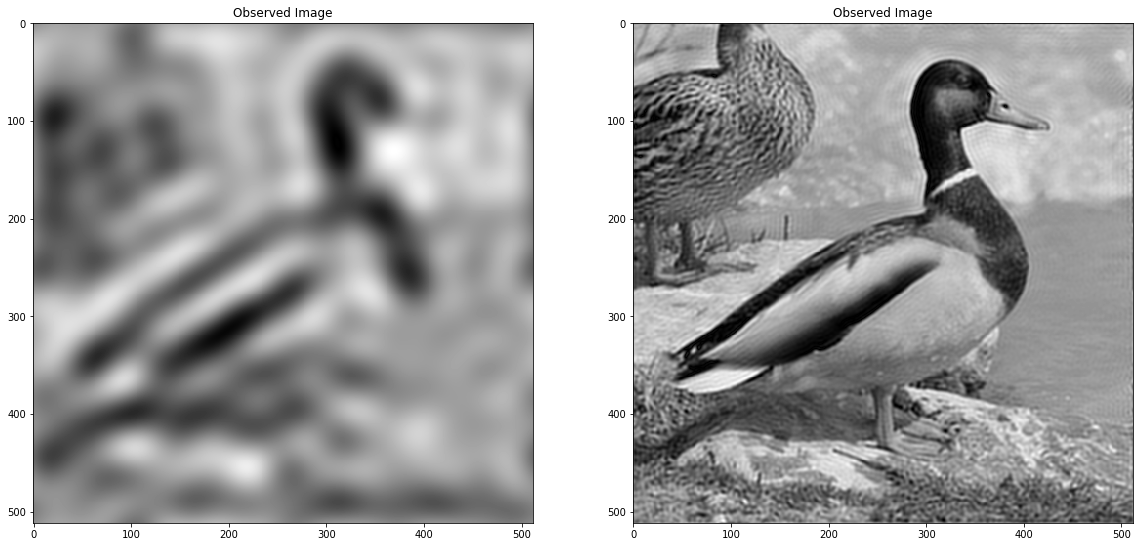

In [14]:
fig, axes = plt.subplots(figsize=(16,8))
fig.tight_layout()

plt.subplot(1,2,1)
obsImg1 = np.abs(np.fft.ifft2(np.fft.fftshift(sampling0 * fftImg1)))
obsPlot = plt.imshow(obsImg1)
obsPlot.set_cmap('gray')
plt.title('Observed Image')

plt.subplot(1,2,2)
obsImg1 = np.abs(np.fft.ifft2(np.fft.fftshift(sampling1 * fftImg1)))
obsPlot = plt.imshow(obsImg1)
obsPlot.set_cmap('gray')
plt.title('Observed Image')

From the left column we can see that a small disk results in a blurred out, or low resolution, image compared to the larger sampling disk in the right column. Because the right column sampling fuction does not fully sample the visibility domain a 'ringing' can be seen in the observed image, especially around the edge of the duck, due to the PSF sidelobes.